`matplotlib` magic command (only necessary for `jupyter` notebooks).

Install and update `cityseer` if necessary.


In [15]:
# !pip install --upgrade cityseer

## Quickstart

`cityseer` revolves around networks (graphs). If you're comfortable with `numpy` and abstract data handling, then the
underlying data structures can be created and manipulated directly. However, it is generally more convenient to sketch
the graph using [`NetworkX`](https://networkx.github.io/) and to let `cityseer` take care of initialising and converting
the graph for you.


/var/folders/bs/sq3p18cs4dn1ws4kpmfyk_3c0000gn/T/ipykernel_87665/1432076598.py:7: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


MultiGraph with 57 nodes and 79 edges


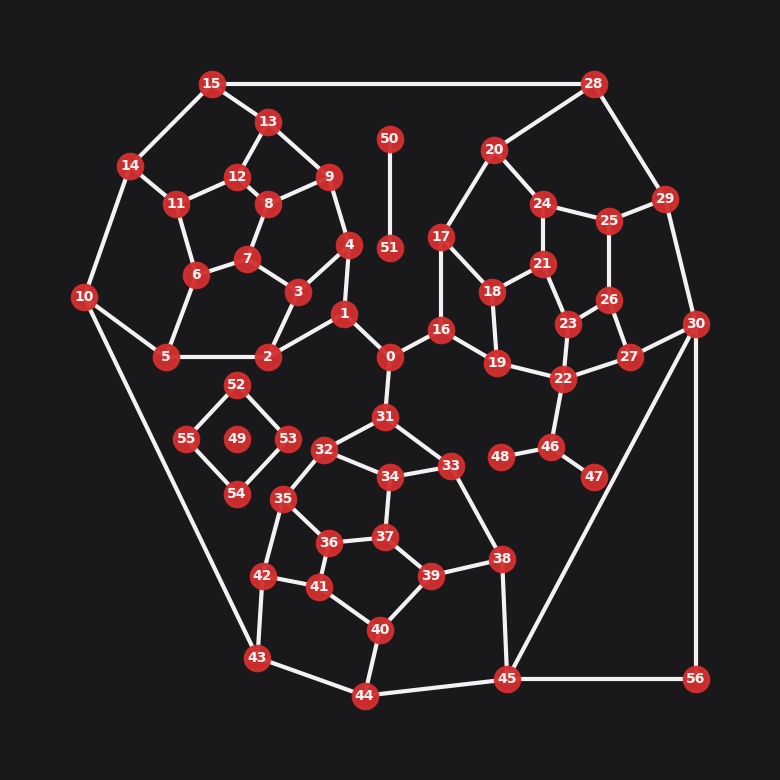

In [16]:
# any networkX MultiGraph with 'x' and 'y' node attributes will do
# here we'll use the cityseer mock module to generate an example networkX graph
import networkx as nx
from cityseer.tools import mock, graphs, plot

G = mock.mock_graph()
print(nx.info(G))
# let's plot the network
plot.plot_nx(G, labels=True, node_size=80, dpi=200, figsize=(4, 4))

## Graph Preparation

The [`tools.graphs`](https://cityseer.benchmarkurbanism.com/tools/graphs/) module contains a collection of convenience functions for the preparation and conversion of `networkX` `MultiGraphs`, i.e. undirected graphs allowing for parallel edges. The [`tools.graphs`](https://cityseer.benchmarkurbanism.com/tools/graphs/) module is designed to work with raw `shapely` [`Linestring`](https://shapely.readthedocs.io/en/latest/manual.html#linestrings) geometries that have been assigned to the graph's edge (link) `geom` attributes. The benefit to this approach is that the geometry of the network is decoupled from the topology: the topology is consequently free from distortions which would otherwise confound centrality and other metrics.

There are generally two scenarios when creating a street network graph:

1. In the ideal case, if you have access to a high-quality street network dataset -- which keeps the topology of the network separate from the geometry of the streets -- then you would construct the network based on the topology while assigning the roadway geometries to the respective edges spanning the nodes. [OS Open Roads](https://www.ordnancesurvey.co.uk/business-and-government/products/os-open-roads.html) is a good example of this type of dataset. Assigning the geometries to an edge involves A) casting the geometry to a [`shapely`](https://shapely.readthedocs.io) `LineString`, and B) assigning this geometry to the respective edge by adding the `LineString` geometry as a `geom` attribute. e.g. `G.add-edge(start_node, end_node, geom=a_linestring_geom)`.

2. In reality, most data-sources are not this refined and will represent roadway geometries by adding additional nodes to the network. For a variety of reasons, this is not ideal and you may want to follow the [`Graph Cleaning`](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning) guide; in these cases, the [`graphs.nx_simple_geoms`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-simple-geoms) method can be used to generate the street geometries, after which several methods can be applied to clean and prepare the graph. For example, [`nx-wgs_to_utm`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-wgs-to-utm) aids coordinate conversions; [`nx_remove_dangling_nodes`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-remove-dangling-nodes) removes remove roadway stubs, [`nx_remove_filler_nodes`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-remove-filler-nodes) strips-out filler nodes, and [`nx-consolidate-nodes`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-consolidate-nodes) assists in cleaning-up the network.

Here, we'll walk through a high-level overview showing how to use `cityseer`. You can provide your own shapely geometries if available; else, you can auto-infer simple geometries from the start to end node of each network edge, which works well for graphs where nodes have been used to inscribe roadway geometries (i.e. OSM).

INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 79/79 [00:00<00:00, 74729.37it/s]


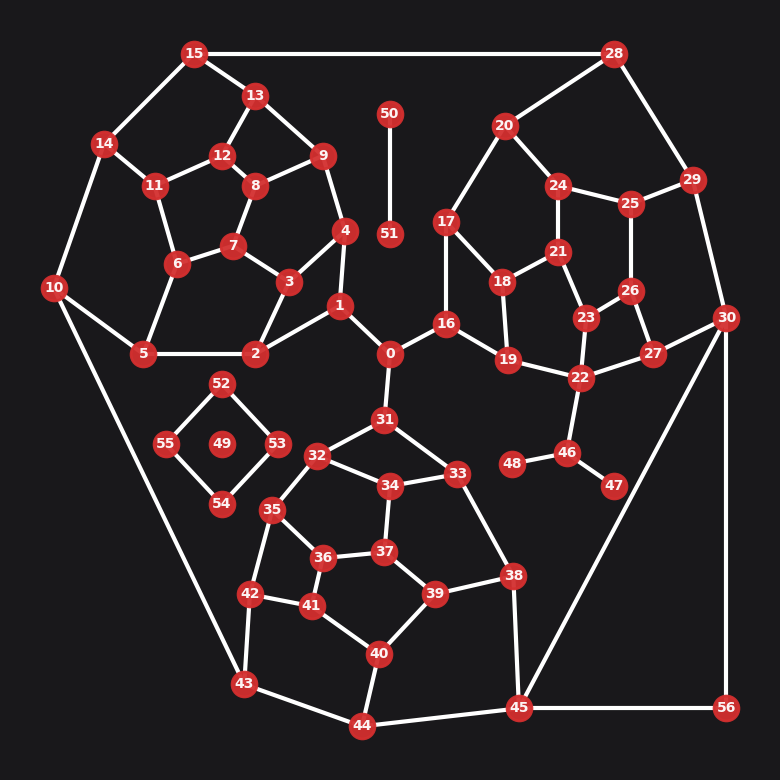

In [17]:
# use nx_simple_geoms to infer geoms for your edges
G = graphs.nx_simple_geoms(G)
plot.plot_nx(G, labels=True, node_size=80, plot_geoms=True, dpi=200, figsize=(4, 4))

We have now inferred geometries for each edge, meaning that each edge now has an associated `LineString` geometry. Any further manipulation of the graph using the `cityseer.graph` module will retain and further manipulate these geometries in-place.

Once the geoms are readied, we can use tools such as [`nx_decompose`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-decompose) for generating granular graph representations and [`nx_to_dual`](https://cityseer.benchmarkurbanism.com/tools/graphs#nx-to-dual) for casting a primal graph representation to its dual.


INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 50.
100%|██████████| 79/79 [00:00<00:00, 233.81it/s]


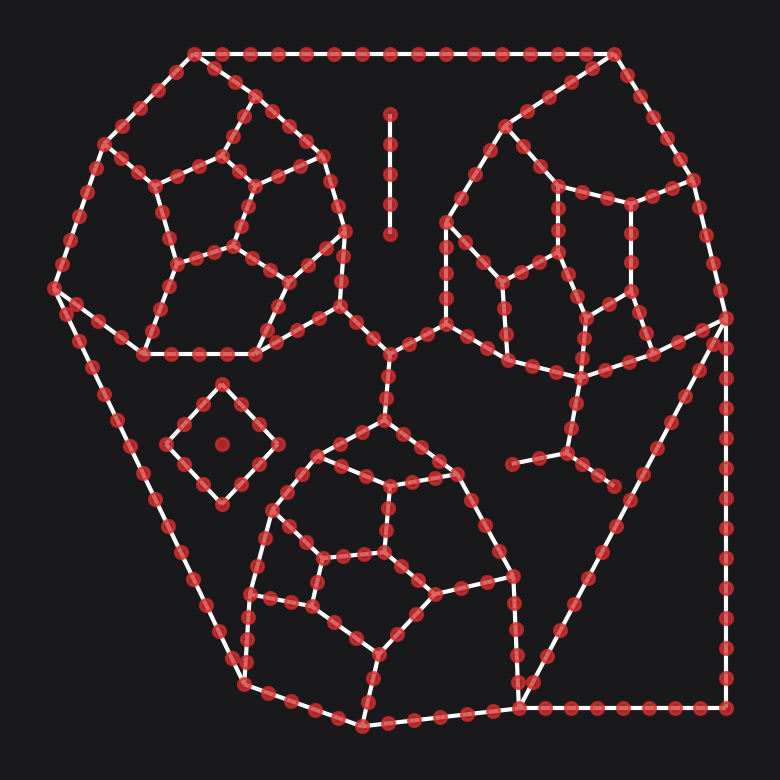

In [18]:
# this will (optionally) decompose the graph
G_decomp = graphs.nx_decompose(G, 50)
plot.plot_nx(G_decomp, plot_geoms=True, labels=False, dpi=200, figsize=(4, 4))

INFO:cityseer.tools.graphs:Converting graph to dual.
100%|██████████| 79/79 [00:00<00:00, 465.84it/s]


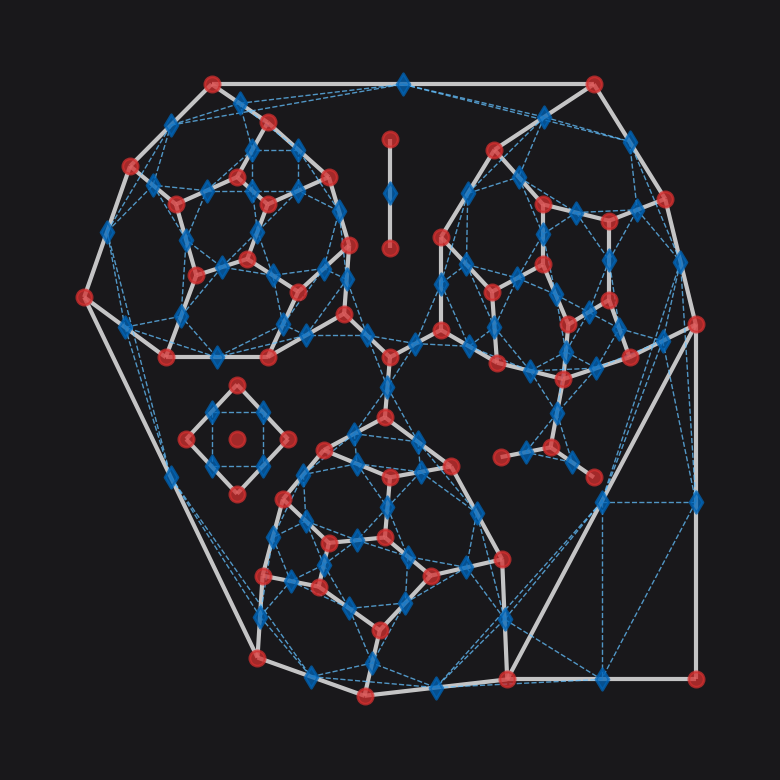

In [19]:
# this will (optionally) cast to a dual network
G_dual = graphs.nx_to_dual(G)
# here we are plotting the newly decomposed graph (blue) against the original graph (red)
plot.plot_nx_primal_or_dual(G, G_dual, plot_geoms=False, dpi=200, figsize=(4, 4))

## Metrics

After graph preparation and cleaning has been completed, the `networkX` graph can be transformed into data structures for efficiently computing centralities, land-use measures, or statistical aggregations.

Use [network_structure_from_nx](https://cityseer.benchmarkurbanism.com/metrics/networks#network-structure-from-nx) to convert a `networkX` graph into a GeoPandas [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) and a [`structures.NetworkStructure`](https://cityseer.benchmarkurbanism.com/structures#networkstructure), which is used by Cityseer for efficiently computing over the network.


### Network Centralities

The [`networks.node_centrality`](https://cityseer.benchmarkurbanism.com/metrics/networks#node-centrality) and [`networks.segment_centrality`](https://cityseer.benchmarkurbanism.com/metrics/networks#segment-centrality) methods wrap underlying numba optimised functions that compute a range of centrality methods. All selected measures and distance thresholds are computed simultaneously to reduce the amount of time required for multi-variable and multi-scalar workflows. The results of the computations will be written to the `GeoDataFrame`.

> Cityseer uses `Numba` to compile functions such as `node_centrality` and `segment_centrality` to fast "jitted" code. The compilation happens the first time the function is invoked, which takes a few seconds to complete. Once jitted, the compiled functions will have been cached and subsequent invocations will start instantly.


In [29]:
from cityseer.metrics import networks

# create a Network layer from the networkX graph
# use a CRS EPSG code matching the projected coordinate reference system for your data
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=3395)
# the underlying method allows the computation of various centralities simultaneously, e.g.
nodes_gdf = networks.segment_centrality(
    measures=["segment_harmonic", "segment_betweenness"],  # the form of centrality measures to compute - see docs
    network_structure=network_structure,  # the network structure for which to compute the measures
    nodes_gdf=nodes_gdf,  # the nodes GeoDataFrame, to which the results will be written
    distances=[200, 400, 800, 1600],  # the distance thresholds for which to compute centralities
)
nodes_gdf.head()  # the results are now in the GeoDataFrame

INFO:cityseer.tools.graphs:Preparing node and edge arrays from networkX graph.
100%|██████████| 292/292 [00:00<00:00, 3056.75it/s]
INFO:cityseer.metrics.networks:Computing node_density centrality measures using shortest (non-angular) path heuristic.


100%|██████████| 292.0/292 [00:06<00:00, 42.15it/s]  


/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/centrality.py:268: NumbaWarning: Cannot cache compiled function "local_node_centrality" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True, fastmath=config.FASTMATH, nogil=True, parallel=True)


,live,geometry,cc_metric_node_density_200,cc_metric_node_density_400,cc_metric_node_density_800,cc_metric_node_density_1600
node_key,,,,,,
0,True,POINT (700700.000 5719700.000),19.0,60.0,213.0,273.0
1,True,POINT (700610.000 5719780.000),16.0,50.0,191.0,273.0
2,True,POINT (700460.000 5719700.000),13.0,43.0,142.0,273.0
3,True,POINT (700520.000 5719820.000),17.0,50.0,126.0,273.0
4,True,POINT (700620.000 5719905.000),15.0,52.0,161.0,273.0


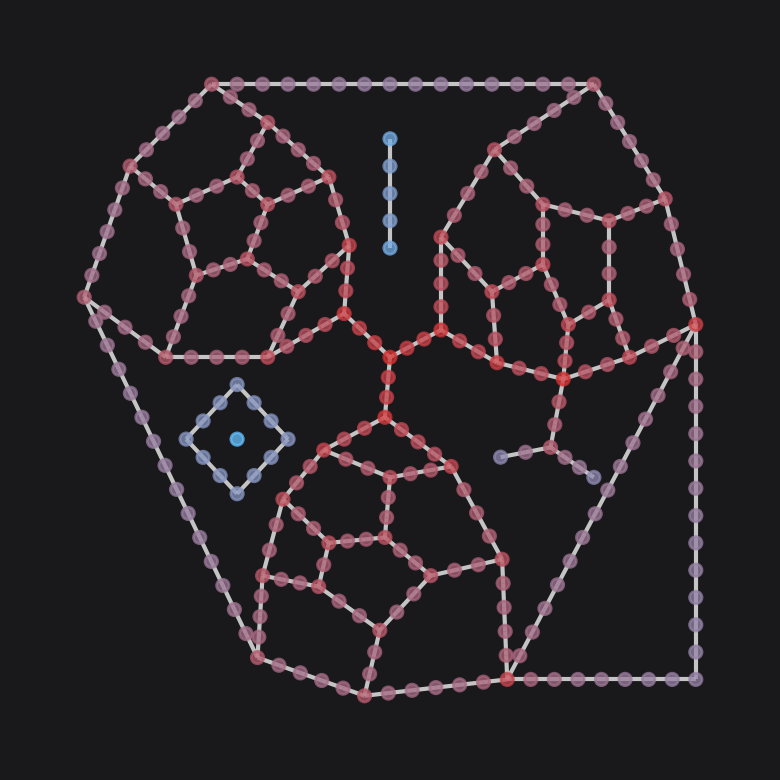

In [21]:
# plot centrality
from matplotlib import colors

# custom colourmap
cmap = colors.LinearSegmentedColormap.from_list("cityseer", ["#64c1ff", "#d32f2f"])
# normalise the values
segment_harmonic_vals = nodes_gdf["cc_metric_segment_harmonic_800"]
segment_harmonic_vals = colors.Normalize()(segment_harmonic_vals)
# cast against the colour map
segment_harmonic_cols = cmap(segment_harmonic_vals)
# plot segment_harmonic
# cityseer's plot methods are used here and in tests for convenience
# that said, rather use plotting methods directly from networkX or GeoPandas where possible
plot.plot_nx(G_decomp, labels=False, node_colour=segment_harmonic_cols, dpi=200, figsize=(4, 4))

### Land-use and statistical measures

Landuse and statistical measures require a GeoPandas [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) consisting of `Point` geometries. Columns representing categorical landuse information ("pub", "shop", "school") can be passed to landuse methods, whereas columns representing numerical information can be used for statistical methods.

When computing these measures, `cityseer` will assign each data point to the two closest network nodes — one in either direction — based on the closest adjacent street edge. This enables `cityseer` to use dynamic spatial aggregation methods that more accurately describe distances from the perspective of pedestrians travelling over the network, and relative to the direction of approach.

[`layers.compute_landuses`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-landuses) method is used for the calculation of mixed-use and land-use accessibility measures whereas [`layers.compute_stats`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-stats) can be used for statistical aggregations. As with the centrality methods, the measures are all computed simultaneously (and for all distances); however, simpler stand-alone methods are also available, including [`layers.hill_diversity`](https://cityseer.benchmarkurbanism.com/metrics/layers#hill-diversity), [`layers.hill_branch_wt_diversity`](https://cityseer.benchmarkurbanism.com/metrics/layers#hill-branch-wt-diversity), and [`layers.compute_accessibilities`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-accessibilities).


In [22]:
from cityseer.metrics import layers

# a mock data dictionary representing categorical landuse data
# here randomly generated letters represent fictitious landuse categories
data_gdf = mock.mock_landuse_categorical_data(G_decomp, random_seed=25)
data_gdf.head()

,geometry,categorical_landuses
data_key,,
0,POINT (701144.149 5719228.311),e
1,POINT (700798.732 5719938.464),g
2,POINT (700434.607 5719165.951),h
3,POINT (700323.093 5719450.769),c
4,POINT (700593.320 5719841.434),i


In [23]:
# example easy-wrapper method for computing mixed-uses
# this is a distance weighted form of hill diversity
nodes_gdf, data_gdf = layers.hill_branch_wt_diversity(
    data_gdf,  # the source data
    landuse_column_label="categorical_landuses",  # column in the dataframe which contains the landuse labels
    nodes_gdf=nodes_gdf,  # nodes GeoDataFrame - the results are written here
    network_structure=network_structure,  # measures will be computed relative to pedestrian distances over the network
    distances=[200, 400, 800, 1600],  # distance thresholds for which you want to compute the measures
    qs=[0, 1, 2],  # q parameter for hill mixed uses
)
print(nodes_gdf.columns)  # the GeoDataFrame will contain the results of the calculations
print(nodes_gdf["cc_metric_hill_branch_wt_q0_800"])  # which can be retrieved as needed

100%|██████████| 50.0/50 [00:00<00:00, 19793.79it/s]

INFO:cityseer.metrics.layers:Computing mixed-use measures: hill_branch_wt



100%|██████████| 292.0/292 [00:00<00:00, 32240.10it/s]
Index(['live', 'geometry', 'cc_metric_segment_harmonic_200',
       'cc_metric_segment_harmonic_400', 'cc_metric_segment_harmonic_800',
       'cc_metric_segment_harmonic_1600', 'cc_metric_segment_betweenness_200',
       'cc_metric_segment_betweenness_400',
       'cc_metric_segment_betweenness_800',
       'cc_metric_segment_betweenness_1600', 'cc_metric_hill_branch_wt_q0_200',
       'cc_metric_hill_branch_wt_q0_400', 'cc_metric_hill_branch_wt_q0_800',
       'cc_metric_hill_branch_wt_q0_1600', 'cc_metric_hill_branch_wt_q1_200',
       'cc_metric_hill_branch_wt_q1_400', 'cc_metric_hill_branch_wt_q1_800',
       'cc_metric_hill_branch_wt_q1_1600', 'cc_metric_hill_branch_wt_q2_200',
       'cc_metric_hill_branch_wt_q2_400', 'cc_metric_hill_branch_wt_q2_800',
       'cc_metric_hill_branch_wt_q2_1600'],
      dtype='object')
node_key
0          3.253688
1          4.167138
2          2.504156
3          1.953246
4          3.078751

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/plot.py:546: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


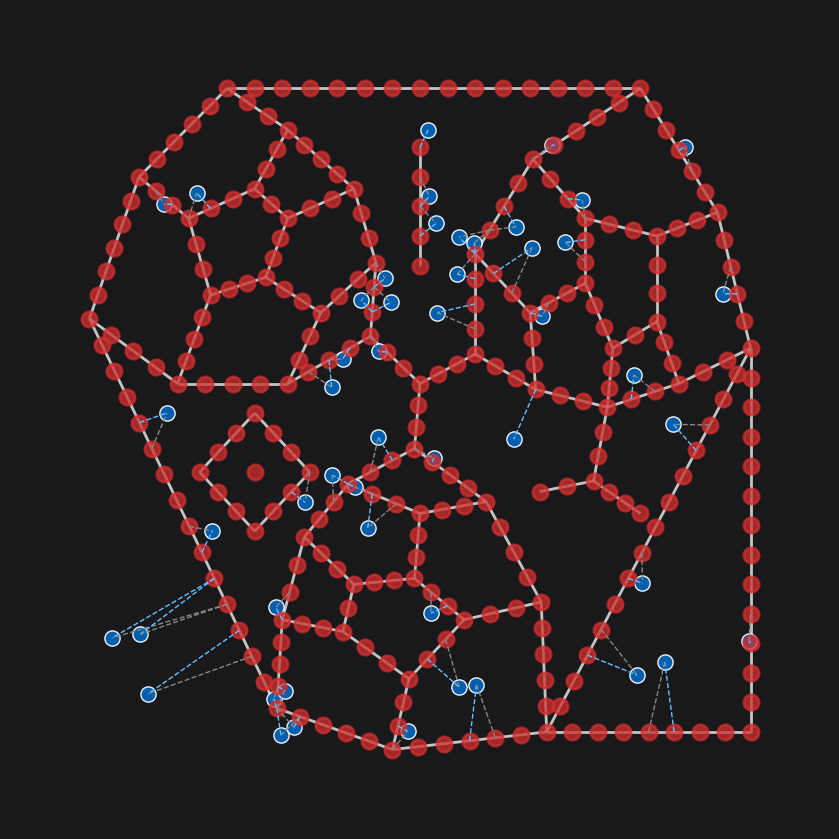

In [24]:
# for curiosity's sake - plot the assignments to see which edges the data points were assigned to
plot.plot_assignment(network_structure, G_decomp, data_gdf, dpi=200, figsize=(4, 4))

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/plot.py:546: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


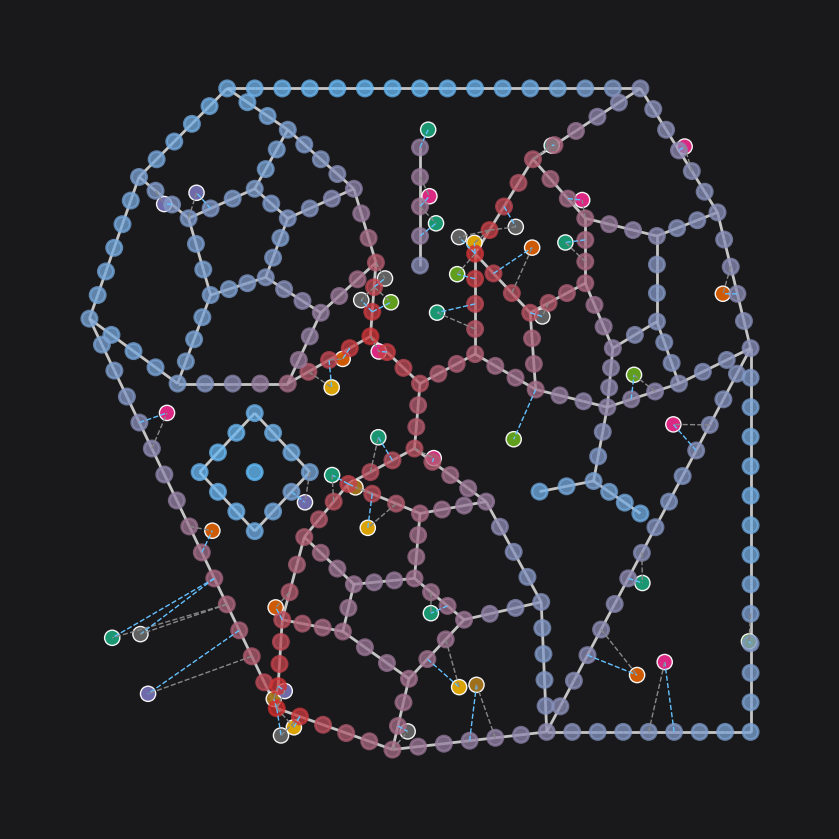

In [25]:
# plot distance-weighted hill mixed uses
mixed_uses_vals = nodes_gdf["cc_metric_hill_branch_wt_q0_800"]
mixed_uses_vals = colors.Normalize()(mixed_uses_vals)
mixed_uses_cols = cmap(mixed_uses_vals)
plot.plot_assignment(
    network_structure,
    G_decomp,
    data_gdf,
    node_colour=mixed_uses_cols,
    data_labels=data_gdf["categorical_landuses"].values,
    dpi=200,
    figsize=(4, 4),
)

In [26]:
# example easy-wrapper method for computing landuse accessibilities
nodes_gdf, data_gdf = layers.compute_accessibilities(
    data_gdf,  # the source data
    landuse_column_label="categorical_landuses",  # column in the dataframe which contains the landuse labels
    accessibility_keys=["a", "b", "c"],  # the landuse categories for which to compute accessibilities
    nodes_gdf=nodes_gdf,  # nodes GeoDataFrame - the results are written here
    network_structure=network_structure,  # measures will be computed relative to pedestrian distances over the network
    distances=[200, 400, 800, 1600],  # distance thresholds for which you want to compute the measures
)
# accessibilities are computed in both weighted and unweighted forms, e.g. for "a" and "b" landuse codes
print(nodes_gdf[["cc_metric_a_800_weighted", "cc_metric_b_1600_non_weighted"]])  # and can be retrieved as needed

INFO:cityseer.metrics.layers:Computing land-use accessibility for: a, b, c


100%|██████████| 292.0/292 [00:00<00:00, 21706.72it/s]
          cc_metric_a_800_weighted  cc_metric_b_1600_non_weighted
node_key                                                         
0                         0.377356                              4
1                         0.206667                              4
2                         0.074647                              4
3                         0.048402                              4
4                         0.093295                              4
...                            ...                            ...
52±1±55                   0.000000                              0
53±0±54                   0.000000                              0
53±1±54                   0.000000                              0
54±0±55                   0.000000                              0
54±1±55                   0.000000                              0

[292 rows x 2 columns]


Aggregations can likewise be computed for numerical data. Let's generate some mock numerical data:


In [27]:
numerical_data_gdf = mock.mock_numerical_data(G_decomp, num_arrs=3)
numerical_data_gdf.head()

# example easy-wrapper method for computing landuse accessibilities
nodes_gdf, numerical_data_gdf = layers.compute_stats(
    numerical_data_gdf,  # the source data
    stats_column_labels=["mock_numerical_1", "mock_numerical_2"],  # numerical columns to compute stats for
    nodes_gdf=nodes_gdf,  # nodes GeoDataFrame - the results are written here
    network_structure=network_structure,  # measures will be computed relative to pedestrian distances over the network
    distances=[800, 1600],  # distance thresholds for which you want to compute the measures
)
# statistical aggregations are calculated for each requested column, and in the following forms:
# max, min, sum, sum_weighted, mean, mean_weighted, variance, variance_weighted

print(nodes_gdf["cc_metric_mock_numerical_2_max_800"])
print(nodes_gdf["cc_metric_mock_numerical_1_mean_weighted_800"])

100%|██████████| 50.0/50 [00:00<00:00, 14898.78it/s]
100%|██████████| 292.0/292 [00:00<00:00, 40476.46it/s]
node_key
0          98.927002
1          98.927002
2          85.971001
3          85.971001
4          85.971001
             ...    
52±1±55    97.767998
53±0±54    97.767998
53±1±54    97.767998
54±0±55    97.767998
54±1±55    97.767998
Name: cc_metric_mock_numerical_2_max_800, Length: 292, dtype: float64
node_key
0          50.337503
1          51.937808
2          45.726648
3          50.008494
4          54.152690
             ...    
52±1±55     1.913000
53±0±54     1.913000
53±1±54     1.913000
54±0±55     1.913000
54±1±55     1.913000
Name: cc_metric_mock_numerical_1_mean_weighted_800, Length: 292, dtype: float64


The landuse metrics and statistical aggregations are computed over the street network relative to the network, with results written to each node. The mixed-use, accessibility, and statistical aggregations can therefore be compared directly to centrality computations from the same locations, and can be correlated or otherwise compared.

Data derived from metrics can be converted back into a `NetworkX` graph using the [nx_from_network_structure](https://cityseer.benchmarkurbanism.com/metrics/networks#nx-from-network-structure) method, or can otherwise be used to overlay computed metrics onto the original graph by providing the `nx_multigraph` parameter.


In [28]:
nx_multigraph_round_trip = graphs.nx_from_network_structure(
    nodes_gdf=nodes_gdf, network_structure=network_structure, nx_multigraph=G_decomp
)
nx_multigraph_round_trip.nodes[0]

INFO:cityseer.tools.graphs:Populating node and edge map data to a networkX graph.
INFO:cityseer.tools.graphs:Reusing existing graph as backbone.
INFO:cityseer.tools.graphs:Unpacking node data.
292it [00:00, 5236.27it/s]
INFO:cityseer.tools.graphs:Unpacking edge data.
100%|██████████| 628/628 [00:00<00:00, 14785.50it/s]
INFO:cityseer.tools.graphs:Unpacking metrics to nodes.
292it [00:00, 7052.78it/s]
292it [00:00, 8033.01it/s]
292it [00:00, 7156.34it/s]
292it [00:00, 7694.33it/s]
292it [00:00, 8337.44it/s]
292it [00:00, 7733.68it/s]
292it [00:00, 7615.67it/s]
292it [00:00, 8977.43it/s]
292it [00:00, 8277.37it/s]
292it [00:00, 8173.30it/s]
292it [00:00, 6112.35it/s]
292it [00:00, 8299.64it/s]
292it [00:00, 8850.92it/s]
292it [00:00, 9287.17it/s]
292it [00:00, 9305.59it/s]
292it [00:00, 7670.91it/s]
292it [00:00, 7679.95it/s]
292it [00:00, 9340.72it/s]
292it [00:00, 9456.92it/s]
292it [00:00, 9067.15it/s]
292it [00:00, 8917.42it/s]
292it [00:00, 8783.57it/s]
292it [00:00, 8832.41it/s]
292

{'x': 700700.0,
 'y': 5719700.0,
 'live': True,
 'cc_metric_segment_harmonic_200': 17.57761573791504,
 'cc_metric_segment_harmonic_400': 24.706344604492188,
 'cc_metric_segment_harmonic_800': 36.82270431518555,
 'cc_metric_segment_harmonic_1600': 40.173221588134766,
 'cc_metric_segment_betweenness_200': 590.865966796875,
 'cc_metric_segment_betweenness_400': 2805.016357421875,
 'cc_metric_segment_betweenness_800': 23574.9921875,
 'cc_metric_segment_betweenness_1600': 159337.25,
 'cc_metric_hill_branch_wt_q0_200': 0.2142721265554428,
 'cc_metric_hill_branch_wt_q0_400': 1.257603406906128,
 'cc_metric_hill_branch_wt_q0_800': 3.253687858581543,
 'cc_metric_hill_branch_wt_q0_1600': 5.520045280456543,
 'cc_metric_hill_branch_wt_q1_200': 0.20572809875011444,
 'cc_metric_hill_branch_wt_q1_400': 1.1793054342269897,
 'cc_metric_hill_branch_wt_q1_800': 3.142047882080078,
 'cc_metric_hill_branch_wt_q1_1600': 5.3164215087890625,
 'cc_metric_hill_branch_wt_q2_200': 0.19956743717193604,
 'cc_metric_h